<a href="https://colab.research.google.com/github/serg-kas/Seams-segm/blob/master/Model_Unet_3_(orig_size).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seams semantic segmentation

### Подготовка окружения

In [1]:
!git clone https://github.com/serg-kas/Seams-segm
%cd Seams-segm
!ls

Cloning into 'Seams-segm'...
remote: Enumerating objects: 600, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 600 (delta 2), reused 1 (delta 0), pack-reused 591
Receiving objects: 100% (600/600), 128.64 MiB | 46.68 MiB/s, done.
Resolving deltas: 100% (105/105), done.
/content/Seams-segm
imgs   Model_Unet_1.ipynb  prep_data.py  unet.py
masks  Model_Unet_2.ipynb  README.md	 utils.py


In [2]:
# Импорт библиотек
import numpy as np
import math
import cv2 as cv
import random
import os
import time
#
import utils as u 
import unet
#
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D
from tensorflow.keras.layers import Reshape, GlobalAveragePooling2D, UpSampling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import backend as K        
from keras.callbacks import ReduceLROnPlateau, EarlyStopping 
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.utils import plot_model
#
import albumentations as A
#
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Подключим google disk
from google.colab import drive 
drive.mount('/content/drive')

# Путь к папке с данным
PATH = '/content/drive/MyDrive/my_data/Seams-segm/'

!ls {PATH}

Mounted at /content/drive
 00-Unet    out1    test2	  'Архив-Unet-3 (обучение с весов Unet-1)'
 imgs_fs    out2    Архив-Unet-1  'Архив-Unet-3 (обучение с нуля)'
 masks_fs   test1   Архив-Unet-2


In [4]:
# Скопируем данные с google диска в колаб
cur_time = time.time()

!cp -r {PATH + 'imgs_fs'} /content/imgs_fs
!cp -r {PATH + 'masks_fs'} /content/masks_fs

print("Время выполнения: ", round(time.time() - cur_time, 2), 'c', sep='')

Время выполнения: 44.85c


In [5]:
# Пути к данным
images_path = "/content/imgs_fs"
anns_path = "/content/masks_fs"

In [6]:
# Создадим списки файлов с путями к ним
img_names= [ os.path.join(images_path, file_name) for file_name in os.listdir(images_path)]
ann_names = [ os.path.join(anns_path, file_name) for file_name in os.listdir(anns_path)]

In [ ]:
# Посмотрим каких размеров картинки в датасете
dict = {}
cur_time = time.time()
for file_name  in img_names:
    img = cv.imread(file_name)
    if str(img.shape) in dict.keys():
        dict[str(img.shape)] += 1
    else:
        dict[str(img.shape)] = 1
    
print("Имеем картинок: {}".format(len(img_names)))
print("Встречаются размеры: {}".format(dict))
print("Время выполнения: ", round(time.time() - cur_time, 2), 'c', sep='')

Имеем картинок: 41
Встречаются размеры: {'(5803, 6420, 3)': 1, '(5858, 6484, 3)': 1, '(3278, 3278, 3)': 8, '(6554, 6554, 3)': 5, '(3278, 4374, 3)': 1, '(4430, 6421, 3)': 1, '(6094, 12449, 3)': 1, '(5696, 6440, 3)': 1, '(6318, 6318, 3)': 1, '(5793, 6149, 3)': 1, '(5646, 6368, 3)': 1, '(5179, 4699, 3)': 1, '(6496, 5486, 3)': 1, '(2976, 6536, 3)': 1, '(6016, 6426, 3)': 1, '(6042, 4904, 3)': 1, '(6077, 6300, 3)': 1, '(6478, 6030, 3)': 1, '(4762, 6554, 3)': 1, '(6292, 6510, 3)': 1, '(2858, 3278, 3)': 1, '(5737, 6554, 3)': 1, '(4882, 6486, 3)': 1, '(6433, 6423, 3)': 1, '(6458, 4200, 3)': 1, '(6333, 6271, 3)': 1, '(6554, 5224, 3)': 1, '(6416, 5736, 3)': 1, '(6382, 6382, 3)': 1, '(4468, 6400, 3)': 1}
Время выполнения: 31.67c


In [ ]:
# Соберем информацию о классах разметки сегментации
ann_set = np.array([])
cur_time = time.time()
for file_name  in ann_names:
    ann = cv.imread(file_name,0)
    # print(ann.shape)
    curr_set = np.unique(ann)
    ann_set = np.union1d(ann_set, curr_set)
    
print("Получили классы разметки: {}".format(ann_set))
print("Время выполнения: ", round(time.time() - cur_time, 2), 'c', sep='')

Получили классы разметки: [  0. 255.]
Время выполнения: 27.07c


In [7]:
# Классы сегментации
# 0 - швы
# 255 - плитка (кирпич, доска)
classes = [0, 255]

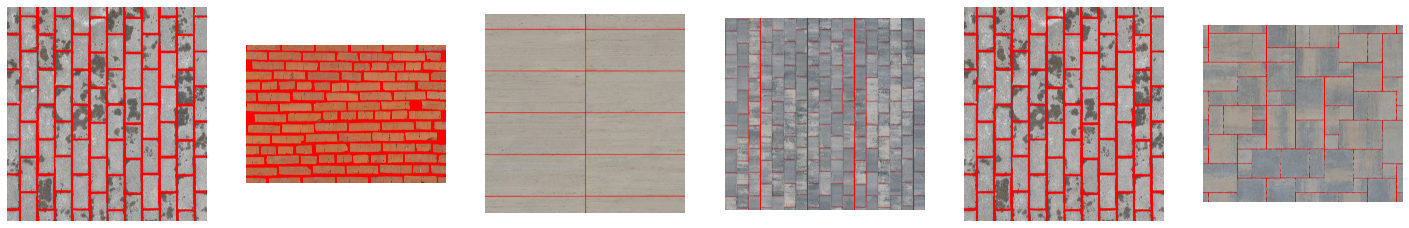

In [ ]:
# Посмотрим несколько случайных картинок из тренировочной выборки.
# Швы из разметки выделим КРАСНЫМ цветом.
n = 6
fig, axs = plt.subplots(1, n, figsize=(25, 10))  

n_files = random.choices(img_names, k=n) 

for i,file in enumerate(n_files):                               
  image = cv.imread(file)
  image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
  ann = cv.imread(os.path.join(anns_path, os.path.basename(file)), 0) 
    
  ones = np.ones((ann.shape[0], ann.shape[1], 3),dtype = np.uint8)
  
  image[:, :, 0] = np.where(ann == 255, image[:, :, 0], ones[:, :, 0] * 255)
  image[:, :, 1] = np.where(ann == 255, image[:, :, 1], ones[:, :, 0] * 0)
  image[:, :, 2] = np.where(ann == 255, image[:, :, 2], ones[:, :, 0] * 0)

  axs[i].axis('off')
  axs[i].imshow(image)             

plt.show() 

**Несолько случайных картинок из датасета. Разметка (швы) прорисована для наглядности красным цветом**

### Функция генератор данных

In [ ]:
# Размеры, к которым приводим изображение для нейронки
img_height = 512
img_width = 512        

In [ ]:
# Функция - генератор данных
def generate_data(batchsize):
    # Объявляем аугментацию
    transform = A.Compose([
        A.Resize(height=img_height, width=img_width),
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomCrop(int(img_height * 0.5), int(img_width * 0.5), p=1),
            A.RandomCrop(int(img_height * 0.75), int(img_width * 0.75), p=1),
            A.RandomCrop(int(img_height * 0.9), int(img_width * 0.9), p=1),
        ], p=0.9),
        A.Resize(height=img_height, width=img_width),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.5),
        A.OneOf([
            A.MotionBlur(blur_limit=15, p=1),
            A.Blur(blur_limit=15, p=1),
        ], p=0.2),
    ])

    x_data = []
    y_data = []
    batchcount = 0
    while True:
        # Берем картинку
        file_name = random.choice(img_names)
        curr_image = cv.imread(file_name)

        # Делаем коррекцию контраста
        curr_image = u.autocontrast(curr_image)

        # Переходим к RGB
        curr_image = cv.cvtColor(curr_image, cv.COLOR_BGR2RGB)

        # Берем аннотацию
        curr_ann = cv.imread(os.path.join(anns_path, os.path.basename(file_name)), 0)

        # делаем аугментацию
        transformed = transform(image=curr_image, mask=curr_ann)
        transformed_image = transformed['image']
        transformed_ann = transformed['mask']

        # переходим к диапазону 0 до 1 и отправляем картинку в список
        x_data.append(transformed_image / 255.)

        # классы аннотации переводим ohe и отправляем в список
        y_data.append(u.mask_to_ohe(transformed_ann))

        batchcount += 1
        if batchcount >= batchsize:
            X = np.array(x_data, dtype='float32')
            y = np.array(y_data, dtype='float32')
            yield (X, y)
            x_data = []
            y_data = []
            batchcount = 0


### Функция генератор данных - 2

Используются картинки в полном разрешении, из которых рандомно вырезаются фрагменты 512 х 512 для подачи в модель.
Каждый батч наполняется из одной картинки.
Аугментация не будет включать в себя Crop и Resize

In [8]:
# Размеры, к которым приводим изображение для нейронки
img_height = 512
img_width = 512  

In [9]:
# Функция - генератор данных
def generate_data_fs(batchsize):
    # Объявляем аугментацию
    transform = A.Compose([
        # A.Resize(height=img_height, width=img_width),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        # A.OneOf([
            # A.RandomCrop(int(img_height * 0.5), int(img_width * 0.5), p=1),
            # A.RandomCrop(int(img_height * 0.75), int(img_width * 0.75), p=1),
            # A.RandomCrop(int(img_height * 0.9), int(img_width * 0.9), p=1),
        # ], p=0.9),
        # A.Resize(height=img_height, width=img_width),
        A.RandomBrightnessContrast(p=0.5),
        A.HueSaturationValue(p=0.5),
        A.OneOf([
            A.MotionBlur(blur_limit=15, p=1),
            A.Blur(blur_limit=15, p=1),
        ], p=0.2),
    ])

    x_data = []
    y_data = []
    batchcount = 0

    # Берем картинку
    file_name = random.choice(img_names)
    full_image = cv.imread(file_name)

    # Сохраним размеры текущей картинки
    full_height = full_image.shape[0]
    full_width = full_image.shape[1]          
    assert full_height > img_height
    assert full_width > img_width

    # Делаем коррекцию контраста
    full_image = u.autocontrast(full_image)

    # Переходим к RGB
    full_image = cv.cvtColor(full_image, cv.COLOR_BGR2RGB)

    # Берем аннотацию
    full_ann = cv.imread(os.path.join(anns_path, os.path.basename(file_name)), 0)

    # print(full_image.shape,full_ann.shape)

    while True:
        # Берем случайную точку на изображении 
        point_x = random.randrange(0, full_width - img_width, 2)
        point_y = random.randrange(0, full_height - img_height, 2)
        
        curr_image = full_image[point_y:point_y+img_height, point_x:point_x+img_width]
        curr_ann = full_ann[point_y:point_y+img_height, point_x:point_x+img_width]
        # print(point_y,point_x,curr_image.shape, curr_ann.shape)

        # Чтобы не попадалось картинок без разметки
        if (np.sum(curr_ann) > (255 * 512 * 512 - 512)  ):
          # print(np.sum(curr_ann))
          continue

        # делаем аугментацию
        transformed = transform(image=curr_image, mask=curr_ann)
        transformed_image = transformed['image']
        transformed_ann = transformed['mask']

        # переходим к диапазону 0 до 1 и отправляем картинку в список
        x_data.append(transformed_image / 255.)

        # классы аннотации переводим ohe и отправляем в список
        y_data.append(u.mask_to_ohe(transformed_ann))

        # print(transformed_image.shape, transformed_ann.shape)

        batchcount += 1
        if batchcount >= batchsize:
            X = np.array(x_data, dtype='float32')
            y = np.array(y_data, dtype='float32')
            yield (X, y)
            x_data = []
            y_data = []
            batchcount = 0


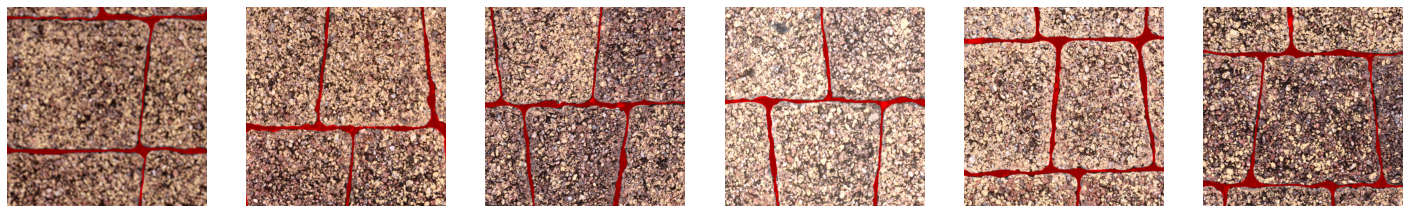

In [13]:
# Посмотрим несколько подготовленных картинок после предобработки и аугментации
# Швы из разметки выделим КРАСНЫМ цветом с прозрачностью
n = 6
g = generate_data_fs(n)
images, anns = next(g)

fig, axs = plt.subplots(1, n, figsize=(25, 10))  

for i in range(n): 
  
  image = (images[i] * 255).astype(np.uint8)
  ann = u.ohe_to_mask(anns[i]) 
  
  ones = np.ones((ann.shape[0], ann.shape[1], 3),dtype = np.uint8)

  image[:, :, 0] = np.where(ann == 255, image[:, :, 0], image[:, :, 0] * 0.5 + ones[:, :, 0] * 255 * 0.5)
  image[:, :, 1] = np.where(ann == 255, image[:, :, 1], ones[:, :, 0] * 0)
  image[:, :, 2] = np.where(ann == 255, image[:, :, 2], ones[:, :, 0] * 0)

  
  axs[i].axis('off')
  axs[i].imshow(image)             

plt.show()   

**Несколько случайных картинок в том виде, как они подаются для обучения нейронки. Разметка (швы) прорисована для наглядности красным цветом**

### Unet - создание и предварительное обучение модели

In [ ]:
# Создаем модель
num_classes = len(classes)
modelUnet = unet.unet(num_classes, (img_height, img_width, 3))
# modelUnet.summary()
# plot_model(modelUnet, to_file="/content/modelUnet.png", show_shapes=True)

In [ ]:
# Запускаем обучение
batch_size = 5
history = modelUnet.fit(generate_data_fs(batch_size),steps_per_epoch= 100/batch_size, epochs=100)

Epoch 1/100
20/20 [==============================] - 47s 1s/step - loss: 0.3946 - dice_coef: 0.7740
Epoch 2/100
20/20 [==============================] - 22s 1s/step - loss: 0.2727 - dice_coef: 0.8476
Epoch 3/100
20/20 [==============================] - 22s 1s/step - loss: 0.2339 - dice_coef: 0.8584
Epoch 4/100
20/20 [==============================] - 23s 1s/step - loss: 0.2088 - dice_coef: 0.8765
Epoch 5/100
20/20 [==============================] - 24s 1s/step - loss: 0.1966 - dice_coef: 0.8866
Epoch 6/100
20/20 [==============================] - 23s 1s/step - loss: 0.1702 - dice_coef: 0.8980
Epoch 7/100
20/20 [==============================] - 23s 1s/step - loss: 0.1969 - dice_coef: 0.8883
Epoch 8/100
20/20 [==============================] - 23s 1s/step - loss: 0.1576 - dice_coef: 0.9077
Epoch 9/100
20/20 [==============================] - 23s 1s/step - loss: 0.1680 - dice_coef: 0.9029
Epoch 10/100
20/20 [==============================] - 23s 1s/step - loss: 0.1998 - dice_coef: 0.8844

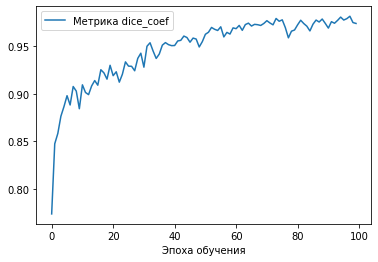

In [ ]:
# График точности обучения
plt.plot(history.history['dice_coef'], label='Метрика dice_coef')
plt.xlabel('Эпоха обучения')
plt.legend()
plt.show()

**Результат пробного обучения неплохой. Видно что потенциал обучения не исчерпан (тренд графика точности смотрит вверх)**

In [ ]:
# Сохраняем модель
model_file = os.path.join(PATH, '00-Unet')
modelUnet.save(model_file, save_format='tf')

model_file = os.path.join(PATH, '00-Unet.h5')
modelUnet.save(model_file)

!ls {PATH}

 00-Unet      out1    Архив-Unet-1
 00-Unet.h5   out2    Архив-Unet-2
 imgs_fs      test1  'Архив-Unet-3 (обучение с весов Unet-1-00)'
 masks_fs     test2  'Архив-Unet-3 (обучение с нуля)'


### Unet - дообучение

In [ ]:
!ls {PATH}

00-Unet  00-Unet.h5  out1  out2  test1	test2  Архив-Unet-1


In [ ]:
# Дообучаем
model_file = os.path.join(PATH, '00-Unet')
model = load_model(model_file, custom_objects={'dice_coef':unet.dice_coef})

lr = 0.001
history_list = []

# Определим коллбэки
reduce_lr = ReduceLROnPlateau(monitor='dice_coef', 
                              patience=10, 
                              verbose=1, 
                              factor=0.5, 
                              min_lr=0.000001)
earlystopper = EarlyStopping(patience=15,
                             verbose=1,
                             monitor='dice_coef',
                             restore_best_weights=True)

for N in range(1,2):

  model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=[unet.dice_coef])
  # model.compile(loss='categorical_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['dice_coef'])


  print('\nТренировка: ', N)

  batch_size = 5
  history = model.fit(generate_data(batch_size),
                      steps_per_epoch= 100/batch_size,
                      epochs=500,
                      verbose=1,
                      callbacks=[reduce_lr,earlystopper])

  history_list.append(history)

  file_number = "%02d" % (N)

  model_file = os.path.join(PATH, file_number + '-Unet')
  model.save(model_file, save_format='tf')

  model_file = os.path.join(PATH, file_number + '-Unet.h5')  
  model.save(model_file)


In [ ]:
#Отображаем график точности в процессе обучения
history_dice = []
for N in range(4):
  history_dice += history_list[N].history['dice_coef']

plt.figure(figsize=(16,5))
plt.plot(history_dice, 
         label='dice_coef')
plt.xlabel('Эпоха обучения')
plt.ylabel('Метрики')
plt.legend()
plt.show()

### Предикт и визуализация на обучающих данных

In [29]:
!ls {PATH}

 00-Unet    out1    test2	  'Архив-Unet-3 (обучение с весов Unet-1)'
 imgs_fs    out2    Архив-Unet-1  'Архив-Unet-3 (обучение с нуля)'
 masks_fs   test1   Архив-Unet-2


In [30]:
# Загружаем модель
model_file = os.path.join(PATH, '00-Unet')
model = load_model(model_file, custom_objects={'dice_coef':unet.dice_coef})

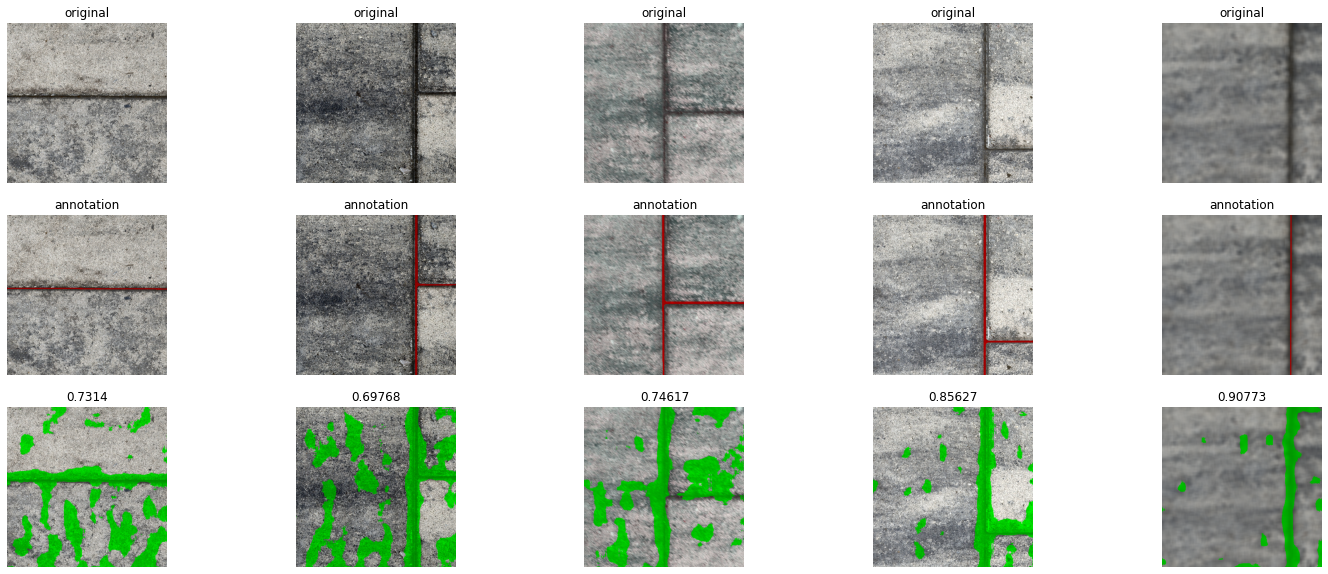

In [31]:
# Предикт и визуализация картинок из generate_data_fs
n = 5
g = generate_data_fs(n)
images, anns = next(g)

fig, axs = plt.subplots(3, n, figsize=(25, 10))  

for i in range(n):
  
    image = (images[i] * 255).astype(np.uint8)
    ann = u.ohe_to_mask(anns[i]) 
    pred= unet.pred_images(model, image, img_height, img_width)
    #
    ones = np.ones((ann.shape[0], ann.shape[1], 3),dtype = np.uint8)
    image_ann = image.copy()
    image_ann[:, :, 0] = np.where(ann == 255, image[:, :, 0], image[:, :, 0] * 0.5 + ones[:, :, 0] * 255 * 0.5)
    image_ann[:, :, 1] = np.where(ann == 255, image[:, :, 1], ones[:, :, 0] * 0)
    image_ann[:, :, 2] = np.where(ann == 255, image[:, :, 2], ones[:, :, 0] * 0)
    #
    ones = np.ones((pred.shape[0], pred.shape[1], 3),dtype = np.uint8)
    image_pred = image.copy()
    image_pred[:, :, 0] = np.where(pred == 255, image[:, :, 0], ones[:, :, 0] * 0)
    image_pred[:, :, 1] = np.where(pred == 255, image[:, :, 1], image[:, :, 1] * 0.5 + ones[:, :, 0] * 255 * 0.5)
    image_pred[:, :, 2] = np.where(pred == 255, image[:, :, 2], ones[:, :, 0] * 0)

    axs[0,i].axis('off')
    axs[0,i].imshow(image)
    axs[0,i].set_title('original')

    axs[1,i].axis('off')
    axs[1,i].imshow(image_ann)  
    axs[1,i].set_title('annotation')

    axs[2,i].axis('off')
    axs[2,i].imshow(image_pred)
    axs[2,i].set_title(round(unet.dice_coef_np(u.mask_to_ohe(ann), u.mask_to_ohe(pred)), 5))
    
plt.show()  

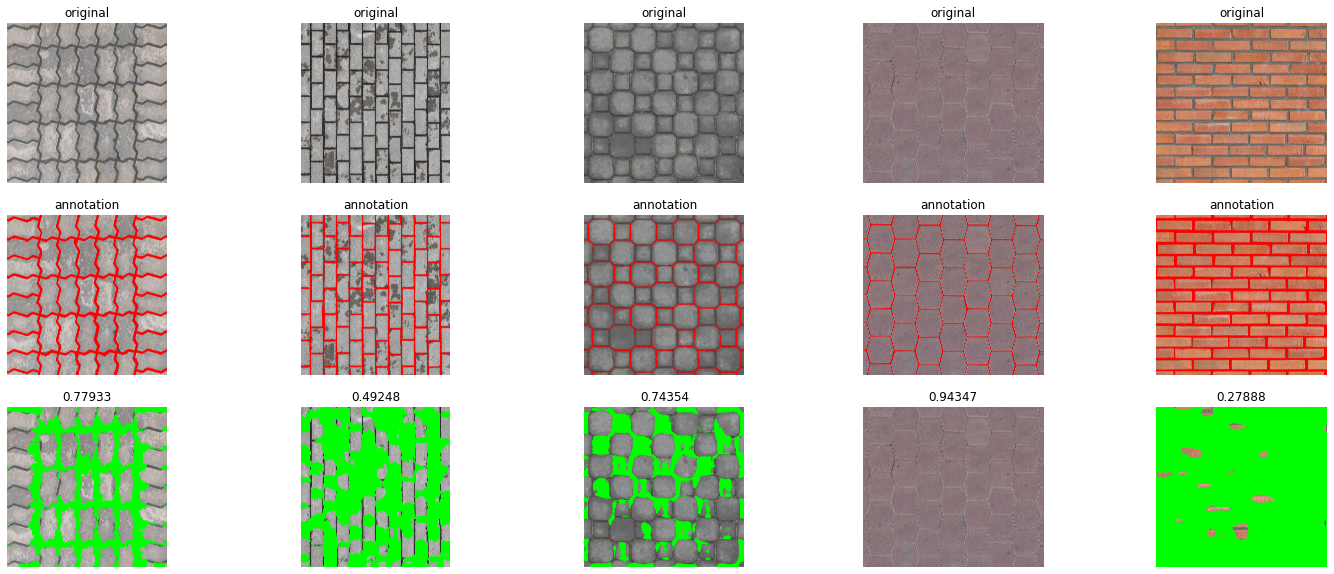

In [32]:
# Предикт и визуализация картинок из generate_data (512x512)
n = 5
fig, axs = plt.subplots(3, n, figsize=(25, 10))  

n_files = random.choices(img_names, k=n) 
for i,file in enumerate(n_files):
    image = cv.imread(file)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    ann = cv.imread(os.path.join(anns_path, os.path.basename(file)), 0)
    pred= unet.pred_images(model, image, img_height, img_width)
    #
    ones = np.ones((ann.shape[0], ann.shape[1], 3),dtype = np.uint8)
    image_ann = image.copy()
    image_ann[:, :, 0] = np.where(ann == 255, image[:, :, 0], ones[:, :, 0] * 255)
    image_ann[:, :, 1] = np.where(ann == 255, image[:, :, 1], ones[:, :, 0] * 0)
    image_ann[:, :, 2] = np.where(ann == 255, image[:, :, 2], ones[:, :, 0] * 0)
    #
    ones = np.ones((pred.shape[0], pred.shape[1], 3),dtype = np.uint8)
    image_pred = image.copy()
    image_pred[:, :, 0] = np.where(pred == 255, image[:, :, 0], ones[:, :, 0] * 0)
    image_pred[:, :, 1] = np.where(pred == 255, image[:, :, 1], ones[:, :, 0] * 255)
    image_pred[:, :, 2] = np.where(pred == 255, image[:, :, 2], ones[:, :, 0] * 0)

    axs[0,i].axis('off')
    axs[0,i].imshow(image)
    axs[0,i].set_title('original')

    axs[1,i].axis('off')
    axs[1,i].imshow(image_ann)  
    axs[1,i].set_title('annotation')

    axs[2,i].axis('off')
    axs[2,i].imshow(image_pred)
    axs[2,i].set_title(round(unet.dice_coef_np(u.mask_to_ohe(ann), u.mask_to_ohe(pred)), 5))
    
plt.show()  

**Предикт на данных из обучающей выборки**

Первый ряд - оригинальные изображения

Ниже - с визуальзацией разметки (красным)

Третий ряд - предикт модели (визуализация зеленым)

### Предикт тестовых изображений с сохранением результатов

In [25]:
!ls {PATH}

 00-Unet    out1    test2	  'Архив-Unet-3 (обучение с весов Unet-1)'
 imgs_fs    out2    Архив-Unet-1  'Архив-Unet-3 (обучение с нуля)'
 masks_fs   test1   Архив-Unet-2


In [ ]:
# Загружаем модель
model_file = os.path.join(PATH, '00-Unet')
model = load_model(model_file, custom_objects={'dice_coef':unet.dice_coef})

In [35]:
# Тестовые картинки
test_path = PATH + 'test2'
out_path = PATH + 'out2'

!ls {test_path}

test1.jpg  test2.jpg


In [36]:
# Создадим список файлов
test_names= [os.path.join(test_path, file_name) for file_name in os.listdir(test_path)]

Сохраняем результат /content/drive/MyDrive/my_data/Seams-segm/out2/out_test2.jpg
Сохраняем результат /content/drive/MyDrive/my_data/Seams-segm/out2/out_test1.jpg


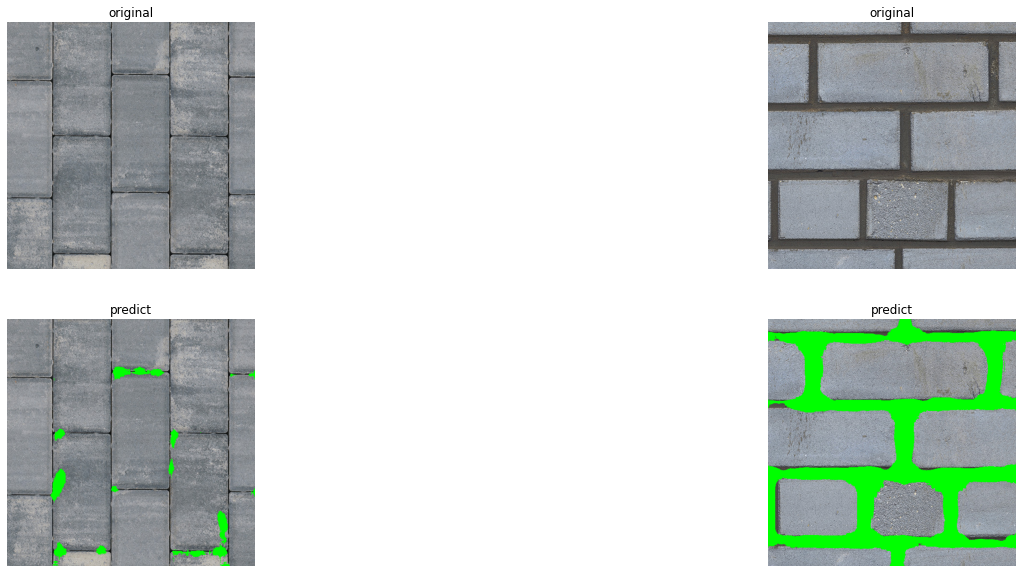

In [37]:
# Предикт и визуализация картинок из test
n = len(test_names)
fig, axs = plt.subplots(2, n, figsize=(25, 10))  

for i,file in enumerate(test_names):
    image = cv.imread(file)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    # 
    pred = unet.pred_images(model, image, img_height, img_width) 
    #
    ones = np.ones((pred.shape[0], pred.shape[1], 3),dtype = np.uint8)
    image_pred = image.copy()
    image_pred[:, :, 0] = np.where(pred == 255, image_pred[:, :, 0], ones[:, :, 0] * 0)
    image_pred[:, :, 1] = np.where(pred == 255, image_pred[:, :, 1], ones[:, :, 0] * 255)
    image_pred[:, :, 2] = np.where(pred == 255, image_pred[:, :, 2], ones[:, :, 0] * 0)

    out_file = os.path.join(out_path, 'out_' + os.path.basename(file))
    print('Сохраняем результат {}'.format(out_file))
    ret = cv.imwrite(out_file, image_pred)
    if ret==False:
      print('Не удалось сохранить: {}'.format(file))

    axs[0,i].axis('off')
    axs[0,i].imshow(image)
    axs[0,i].set_title('original')

    axs[1,i].axis('off')
    axs[1,i].imshow(image_pred)
    axs[1,i].set_title('predict')
    
plt.show()  

**Предикт на тестовых данных,  то есть на данных, которые нейронка не видела в процессе обучения**

